<a href="https://colab.research.google.com/github/BriefCud/PRA3024-Big-Data-in-Physics/blob/master/week%205/ML_cifar_CNN_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Some data-handling functions to download/import.

"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')
    
    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)
    
        

    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)
    

def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):
    
    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]
    
    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)
    
    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')
    
    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])

    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [2]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

1.15.0
2.2.5


Using TensorFlow backend.


In [3]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Dataset not found. Downloading...
Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


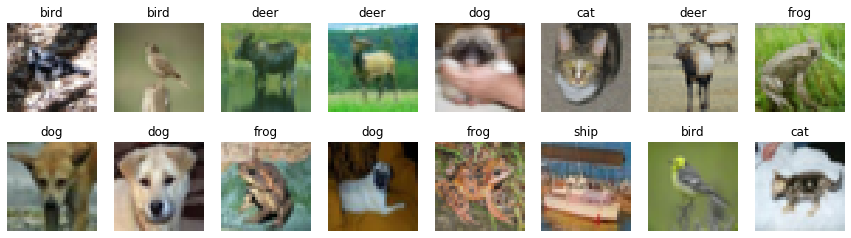

In [4]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [0]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0

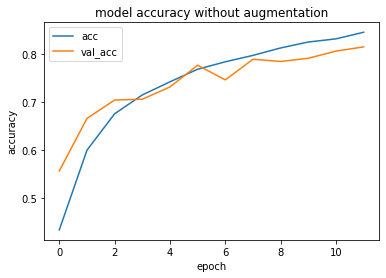

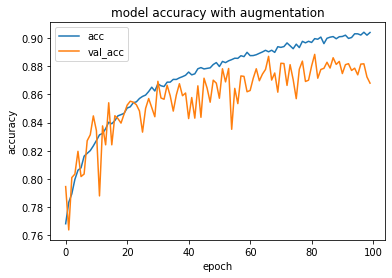

In [6]:
###
### START OF CODE FOR CONVOLUTIONAL NEURAL NETWORK USING KERAS  ###
###

### STUDENT CODE HERE ###
### --> change the parameters below to perform a better training

### Import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras import optimizers

#### Impots needed for tuning the model
# !pip install sklearn
# from sklearn.model_selection import GridSearchCV
# from keras.wrappers.scikit_learn import KerasClassifier

### Imports for data augmentation
from keras.preprocessing.image import ImageDataGenerator

def make_model():
  """
  Returns `Sequential` model.
  """

  model = Sequential()

  ### STUDENT CODE HERE ###
  ### --> Build your convolutional neural network. 

  ### First, make a CNN layer with some small kernels to learn some basic features, with Conv2D.
  model.add(Conv2D(32, (3,3), padding='same', activation="elu", input_shape=x_train.shape[1:]))

  ### Using BatchNormalization to decrease the speed of the CNN
  ### This function is used to reduce covariant shift.
  ### When a layer is executed during the training stage, the parameters of the dataset change,
  ### which also leads to the distribution of input in the current layer to change.
  ### These changes can affect the whole network. Batch normalization reduces this change
  model.add(BatchNormalization()) 

  model.add(Conv2D(32, (3,3), padding='same', activation="elu"))
  model.add(BatchNormalization())

  ### Pooling layer to pick up the relevant kernels.
  model.add(MaxPooling2D((2, 2)))

  ### Using a Dropout layer, to avoid local minima
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3,3), padding='same', activation="elu"))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same', activation="elu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(128, (3,3), padding='same', activation="elu"))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3,3), padding='same', activation="elu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))

  ### Then, Flatten it and add some fully-connected (Dense) normal NN layers,
  ###  to learn the relevant combinations of low-level kernel features.
  model.add(Flatten())

  model.add(Dense(10, activation='softmax'))

  # prepare model for fitting (loss, optimizer, etc)
  model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=optimizers.adam(lr=1e-3),
    metrics=['accuracy']  # report accuracy during training
  )

  model.summary()

  return model


### Tuning the model using GridSearchCV

# classifier_tuner = KerasClassifier(build_fn=make_model)

### Creating dictionary for the values to tune
# parameters = {"batch_size":[32,64,128,256],
#               "optimizer":["adam","rmsprop","adamax"],
#               "activation":["relu","sigmoid","tanh","hard_sigmoid"],
#               "initializer":["lecun_uniform","he_normal","lecun_normal"]
#              }

# ### Using GridSearchCV to tune the model
# grid_search = GridSearchCV(estimator=classifier_tuner,param_grid=parameters,scoring="accuracy",cv=10)

# ### Fitting the model
# grid_search = grid_search.fit(x_train,y_train,epochs=3)

# best_parameters = grid_search.best_parameters
# best_accuracy = grid_search.best_score

### I tried uding this code above which tunes the parameters in the model,
### I was getting the error 'Classification metrics can't handle a mix of multilabel-indicator and multiclass targets' 
### which I could not fix therefore decied to move on


### used these sources to help with my code
### https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
### https://www.youtube.com/watch?v=yYqAvlkRwUQ&list=PLk8YgWh7uSMfNldR184FuyK8La2Z5oEsX&index=7

BATCH_SIZE = 100
EPOCHS = 12

K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

fit_model = model.fit(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
)

### Data Augmentation ###
'''
This process will take an image from the x_train dataset and output manipulated 
images for the CNN to train on, this will increase the accuracy of the model
'''
datagen = ImageDataGenerator(
    rotation_range=5,
    height_shift_range=0.1,
    width_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)


fit_aug = model.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,epochs=100,
                    verbose=1,validation_data=(x_val,y_val))

### Plotting the accuracy to compare model with and without data augmentation

### Without data augmentation
history = fit_model
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy without augmentation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

### With data augmentation
aug_history = fit_aug
plt.plot(aug_history.history['acc'])
plt.plot(aug_history.history['val_acc'])
plt.title('model accuracy with augmentation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

# save weights to file to avoid re-training
model.save_weights("weights.h5")

####### TRIAL AND ERROR DOCUMENTATION ####
### 1.  I added more layers to the model to increase its accuracy whcih worked
### 2.  I changed the number of neurons to make the layers more complex
### 3.  I changed the pixel height and width (the brackets after the neuron size) so the CNN analyses more pixels
### 4.  I changed the pixel height and width and also the pool_size to (3,3) but get an error so i had to change the pool_size back
### 5.  I changed the neuron numbers so the biggest numbers are at the first layers in descending order
### 6.  I decided to bring another two layers after the first 4 CNN layers
### 7.  I changed the activation to hard_sigmoid
### 8.  A Rule To Live By: More data means More time!
### 9.  Changed the activation back to relu and the first Dense layer to sigmoid
### 10. I tried using hyperparameter tuning but I get an error as explained above
### 11. I used data augmentation to increase the accuracy of the model
### 13. Using lasagne framework to create a NN


###
### END OF CODE USING KERAS 
###

In [9]:
###
### START OF CODE FOR CONVOLUTIONAL NEURAL NETWORK USING LASAGNE ###  
###
### got the code from these websites
### https://lasagne.readthedocs.io/en/latest/user/tutorial.html 
### https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py
### I get this error im not sure about 

### Imports for Lasagne
!pip install --upgrade https://github.com/Theano/Theano/archive/master.zip
!pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip
import theano
from theano.tensor.signal import pool
import theano.tensor as T 
import lasagne
import time

def lasagne_cnn():
  ### Input layer and specifying the shape
  network = lasagne.layers.InputLayer(shape=(None,3,32,32))

  network = lasagne.layers.Conv2DLayer(
        network, num_filters=32, filter_size=(5, 5),
        nonlinearity=lasagne.nonlinearities.elu,
        W=lasagne.init.GlorotNormal())
  
  network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

  network = lasagne.layers.Conv2DLayer(
        network, num_filters=32, filter_size=(5, 5),
        nonlinearity=lasagne.nonlinearities.elu)
  
  network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

  network = lasagne.layers.DenseLayer(
        lasagne.layers.dropout(network, p=.5),
        num_units=256,
        nonlinearity=lasagne.nonlinearities.elu)
  
  network = lasagne.layers.DenseLayer(
        lasagne.layers.dropout(network, p=.5),
        num_units=10,
        nonlinearity=lasagne.nonlinearities.softmax)

  return network

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
  assert len(inputs) == len(targets)
  if shuffle:
      indices = np.arange(len(inputs))
      np.random.shuffle(indices)
  for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
      if shuffle:
          excerpt = indices[start_idx:start_idx + batchsize]
      else:
          excerpt = slice(start_idx, start_idx + batchsize)
      yield inputs[excerpt], targets[excerpt]



def train_lasagne_nn(num_epochs=500):

  network = lasagne_cnn()

  # Prepare Theano variables for inputs and targets
  input_var = T.tensor4('inputs')
  target_var = T.ivector('targets')

  # Create a loss expression for training, i.e., a scalar objective we want
  # to minimize (for our multi-class problem, it is the cross-entropy loss):
  prediction = lasagne.layers.get_output(network)
  loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
  loss = loss.mean()
  # We could add some weight decay as well here, see lasagne.regularization.

  # Create update expressions for training, i.e., how to modify the
  # parameters at each training step. Here, we'll use Stochastic Gradient
  # Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
  params = lasagne.layers.get_all_params(network, trainable=True)
  updates = lasagne.updates.nesterov_momentum(
          loss, params, learning_rate=0.01, momentum=0.9)

  # Create a loss expression for validation/testing. The crucial difference
  # here is that we do a deterministic forward pass through the network,
  # disabling dropout layers.
  test_prediction = lasagne.layers.get_output(network, deterministic=True)
  test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                          target_var)
  test_loss = test_loss.mean()
  # As a bonus, also create an expression for the classification accuracy:
  test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                    dtype=theano.config.floatX)

  # Compile a function performing a training step on a mini-batch (by giving
  # the updates dictionary) and returning the corresponding training loss:
  train_fn = theano.function([input_var, target_var], loss, updates=updates)

  # Compile a second function computing the validation loss and accuracy:
  val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

  # Finally, launch the training loop.
  print("Starting training...")
  # We iterate over epochs:
  for epoch in range(num_epochs):
      # In each epoch, we do a full pass over the training data:
      train_err = 0
      train_batches = 0
      start_time = time.time()
      for batch in iterate_minibatches(x_train, y_train, 100, shuffle=True):
          inputs, targets = batch
          train_err += train_fn(inputs, targets)
          train_batches += 1

      # And a full pass over the validation data:
      val_err = 0
      val_acc = 0
      val_batches = 0
      for batch in iterate_minibatches(x_val, y_val, 100, shuffle=False):
          inputs, targets = batch
          err, acc = val_fn(inputs, targets)
          val_err += err
          val_acc += acc
          val_batches += 1

      # Then we print the results for this epoch:
      print("Epoch {} of {} took {:.3f}s".format(
          epoch + 1, num_epochs, time.time() - start_time))
      print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
      print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
      print("  validation accuracy:\t\t{:.2f} %".format(
          val_acc / val_batches * 100))

  # After training, we compute and print the test error:
  test_err = 0
  test_acc = 0
  test_batches = 0
  for batch in iterate_minibatches(X_test, y_test, 100, shuffle=False):
      inputs, targets = batch
      err, acc = val_fn(inputs, targets)
      test_err += err
      test_acc += acc
      test_batches += 1
  print("Final results:")
  print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
  print("  test accuracy:\t\t{:.2f} %".format(
      test_acc / test_batches * 100))

  # Optionally, you could now dump the network weights to a file like this:
  # np.savez('model.npz', *lasagne.layers.get_all_param_values(network))
  #
  # And load them again later on like this:
  # with np.load('model.npz') as f:
  #     param_values = [f['arr_%d' % i] for i in range(len(f.files))]
  # lasagne.layers.set_all_param_values(network, param_values)


  if __name__ == '__main__':
    if ('--help' in sys.argv) or ('-h' in sys.argv):
        print("Trains a neural network on MNIST using Lasagne.")
        print("Usage: %s [MODEL [EPOCHS]]" % sys.argv[0])
        print()
        print("MODEL: 'mlp' for a simple Multi-Layer Perceptron (MLP),")
        print("       'custom_mlp:DEPTH,WIDTH,DROP_IN,DROP_HID' for an MLP")
        print("       with DEPTH hidden layers of WIDTH units, DROP_IN")
        print("       input dropout and DROP_HID hidden dropout,")
        print("       'cnn' for a simple Convolutional Neural Network (CNN).")
        print("EPOCHS: number of training epochs to perform (default: 500)")
    else:
        kwargs = {}
        if len(sys.argv) > 1:
            kwargs['model'] = sys.argv[1]
        if len(sys.argv) > 2:
            kwargs['num_epochs'] = int(sys.argv[2])
        main(**kwargs)



### Training 
train_lasagne_nn()

###
### END OF CODE USING LASAGNE 
###

### END STUDENT CODE ###

     | 29.6MB 2.8MB/s
  Created wheel for Theano: filename=Theano-1.0.4+unknown-cp36-none-any.whl size=2666765 sha256=0e03597cdd64b4a916a06fe526c8419744c293c16a8683f6a3e216ec356b91b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-ojmi4qaf/wheels/33/73/96/0ed263c62a86e2485ea634e0d3ae8169d50fd66e3b252541db
Successfully built Theano
  Found existing installation: Theano 1.0.4
    Uninstalling Theano-1.0.4:
      Successfully uninstalled Theano-1.0.4
     |████████████████████████████████| 235kB 415kB/s 
  Created wheel for Lasagne: filename=Lasagne-0.2.dev1-cp36-none-any.whl size=122797 sha256=31837aac6f12be0c21f42189b2270feccf945be55d5398a5506b527a4d12673c
  Stored in directory: /tmp/pip-ephem-wheel-cache-plyd41lg/wheels/ca/4a/00/87f1777b229481fe76562df7c0cfb993bc88ed0cc37e3f0ed4
Successfully built Lasagne


UnusedInputError: ignored

In [0]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

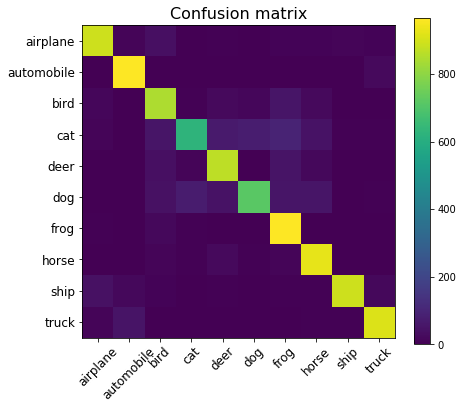

Test accuracy: 0.8624


In [7]:
# make test predictions
y_pred_test = model.predict_proba(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

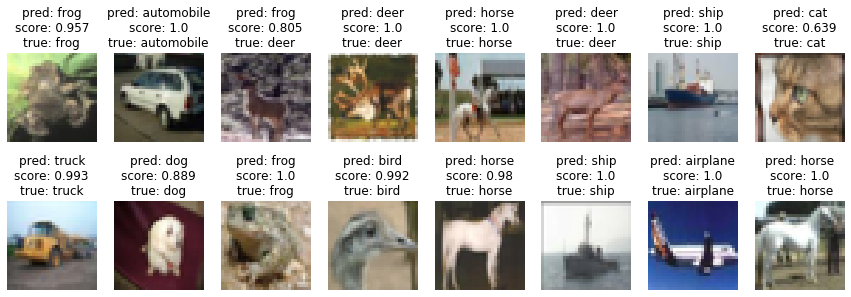

In [8]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)

## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:

 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ - 
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmemntation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.


